<a href="https://colab.research.google.com/github/adamehayman/AMII/blob/main/1_NASA_FD001_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Introduction**  
  
This study aims to prevent unexpected system failure by estimating the remaining useful life (RUL) using predictive analytics derived from multiple sensors that continuously monitor the system's degradation process.
 
Although turbojet aircraft engines were the focus of this study, the methods and models can be applied to other industries that face similar system scheduling and maintenance problems.
Any business that wants to reduce downtime and improve operational efficiencies by modelling system degradation.
Reliably estimating system health and RUL has the potential for considerable operational savings by:  
*  avoiding unscheduled maintenance and downtime  
*  increasing equipment usage and efficiency  
*  avoiding unexpected system failures  
*  increasing operational safety

In [1]:
import numpy as np # for numeric computation
import pandas as pd # for handling data in table format
pd.set_option('display.max_rows', 200)
import requests # for retrieving web addresses
import io # for storing data
import plotly.express as px # for visualization
import math
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
plt.style.use('ggplot')

## **Import Data**

In [2]:
# Clone Git Repo
!git clone -l -s git://github.com/adamehayman/AMII.git cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 32 (delta 5), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (32/32), 11.58 MiB | 2.92 MiB/s, done.
Resolving deltas: 100% (5/5), done.
/content/cloned-repo
NASA_TurboFan_Data  README.md


### **Data Set Overview**
There are four datasets of increasing complexity (see below). Each dataset consists of three files:  

1.   Training set
2.   Test set
3.   RUL set (actual RUL of test set)  

For this study's purpose, we will focus on the dataset FD001. This is because FD001 is the least complex, and we wanted to develop a solid understanding of the data before proceeding to the more complex datasets.  
Each dataset includes simulations of multiple turbofan engines over time until a fault develops. The engine degradation simulation was carried out using NASA's Modular Aero-Propulsion System Simulation (C-MAPSS) software. Simulation data is used as real run-to-failure data for turbofan engines would be far too costly.  
Each engine starts with different degrees of initial normal wear and manufacturing variation, which is unknown. The engine starts in a normal state of operation before developing a fault at some point. The presence of noise further complicates this data.

In [3]:
Dataset_Info = pd.read_excel('/content/cloned-repo/NASA_TurboFan_Data/Dataset_Info.xlsx')
Dataset_Info

,Dataset,Operating Conditions,Fault Modes,Training Size,Testing Size
0,FD001,1,1,100,100
1,FD002,6,1,260,259
2,FD003,1,2,100,100
3,FD004,6,2,248,249


### **Sensor Descriptions**

In [4]:
Sensor_Info = pd.read_excel('/content/cloned-repo/NASA_TurboFan_Data/Sensor_Info.xlsx')
Sensor_Info

,Sensor #,Symbol,Description
0,1,T2,Total temperature at fan inlet
1,2,T24,Total temperature at LPC outlet
2,3,T30,Total temperature at HPC outlet
3,4,T50,Total temperature at LPT outlet
4,5,P2,Pressure at fan inlet
5,6,P15,Total pressure in bypass-duct
6,7,P30,Total pressure at HPC outlet
7,8,Nf,Physical fan speed
8,9,Nc,Physical core speed
9,10,epr,Engine pressure ratio (P50/P2)


### **Data Set FD001**
Train trajectories: 100  
Test trajectories: 100  
Conditions: ONE (Sea Level)  
Fault Modes: One (HPC Degradation)

In [5]:
# define column names
col_names =['Unit','Time','Altitude','Mach Number','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','w31','w32','u1','u2']
print(col_names)

Label_name = 'RUL'

# load first dataset
train1 = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/train_FD001.txt', sep=' ', names=col_names)
test1 = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/test_FD001.txt', sep=' ', names=col_names)
RUL1 = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/RUL_FD001.txt', sep=' ', header=None)

print(train1.shape)
print(test1.shape)
print(RUL1.shape)

['Unit', 'Time', 'Altitude', 'Mach Number', 'TRA', 'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'w31', 'w32', 'u1', 'u2']
(20631, 28)
(13096, 28)
(100, 2)


## **Data Inspection**

#### **Train1 DataFrame**

In [6]:
# Create RUL column and add to the end
# The RUL column takes the max cycle time, grouped by engine unit id, and counts down
# The last RUL datapoint for each engine ID is the equivalent remaining cycles

rul1 = pd.DataFrame(train1.groupby('Unit')['Time'].max()).reset_index()
rul1.columns = ['Unit', 'max']
train1 = train1.merge(rul1, on=['Unit'], how='left')
train1['RUL'] = train1['max'] - train1['Time']
train1.drop('max', axis=1, inplace=True)
train1.head()

,Unit,Time,Altitude,Mach Number,TRA,T2,T24,T30,T50,P2,P15,P30,Nf,Nc,epr,Ps30,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,w31,w32,u1,u2,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN,187


In [7]:
# Select duplicate rows except first occurrence based on all columns
duplicateRowsDFtrain1 = train1[train1.duplicated()]

if duplicateRowsDFtrain1.shape[0] == 0:
    print('no duplicated rows found in train data...')

no duplicated rows found in train data...


In [8]:
df_max_rul = train1[['Unit', 'Time']].groupby('Unit').max().reset_index()
hist = px.histogram(df_max_rul, x='Time',
                    title = 'Engine Cycles Before Fault',
                    labels={'RUL': 'Engine Cycles Before Fault'},
                    nbins=25)
hist.show()

##### **Check for missing values**

In [9]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [10]:
missing_values_table(train1)

Your selected dataframe has 29 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
u1,20631,100.0
u2,20631,100.0


#### **Test1 DataFrame**

**Prepare Test Dataframe: merge test1 with RUL1**

In [11]:
#add columns to RUL1 DF (Unit and RUL_min = RUL at test1 last time cycle) 
initial_value = 1
RUL1['Unit'] = range (initial_value, len(RUL1) + initial_value)
RUL1 = RUL1.rename(columns={0: 'RUL_min'})
RUL1.drop([1], axis='columns', inplace=True)

RUL1.head()

,RUL_min,Unit
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5


In [12]:
#Add the RUL_maxtime for each engine to test1 DF
test1 = test1.merge(RUL1, on=['Unit'], how='left')

In [13]:
# create an "inverse time" column for test1
# Then add a new column RUL to test1 which = RUL1['Unit'] + test1['inverse time']

Inv_time = pd.DataFrame(test1.groupby('Unit')['Time'].max()).reset_index()
Inv_time.columns = ['Unit', 'max_time']
test1 = test1.merge(Inv_time, on=['Unit'], how='left')
test1['Inv_time'] = test1['max_time'] - test1['Time']
test1.drop('max_time', axis=1, inplace=True)
test1['RUL'] = test1['RUL_min']+ test1['Inv_time']
test1.head()

,Unit,Time,Altitude,Mach Number,TRA,T2,T24,T30,T50,P2,P15,P30,Nf,Nc,epr,Ps30,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,w31,w32,u1,u2,RUL_min,Inv_time,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN,112,30,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN,112,29,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN,112,28,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN,112,27,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN,112,26,138


In [14]:
# Select duplicate rows except first occurrence based on all columns
duplicateRowsDFtest1 = test1[test1.duplicated()]
if duplicateRowsDFtest1.shape[0] == 0:
    print('no duplicated rows found in test data...')

no duplicated rows found in test data...


In [15]:
df_max_rul = test1[['Unit', 'RUL']].groupby('Unit').min().reset_index()
hist = px.histogram(df_max_rul, x='RUL',
                    title = 'Engine Cycles',
                    labels={'RUL'},
                    nbins=25)
hist.show()

##### **Check for missing values**

In [16]:
missing_values_table(test1)

Your selected dataframe has 31 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
u1,13096,100.0
u2,13096,100.0


## **Data Analysis**

### **Drop NaN Columns**

In [17]:
# drop off nan col (potential error in model description)
print("shapes prior to removing NaN")
print("Train1 ", train1.shape)
print("Test1 ", test1.shape)
print("RUL1 ",RUL1.shape)
col2drop = ['u1', 'u2']

train1 = train1.drop(col2drop, axis=1)
test1 = test1.drop(col2drop, axis=1)
# RUL1 = RUL1.drop([1], axis=1) This produced an error

# print
print("shapes after to removing NaN")
print("Train1 ",train1.shape)
print("Test1 ", test1.shape)
print("RUL1 ", RUL1.shape)

shapes prior to removing NaN
Train1  (20631, 29)
Test1  (13096, 31)
RUL1  (100, 2)
shapes after to removing NaN
Train1  (20631, 27)
Test1  (13096, 29)
RUL1  (100, 2)


### **Sensor Values vs Time** 

#### **History plot**

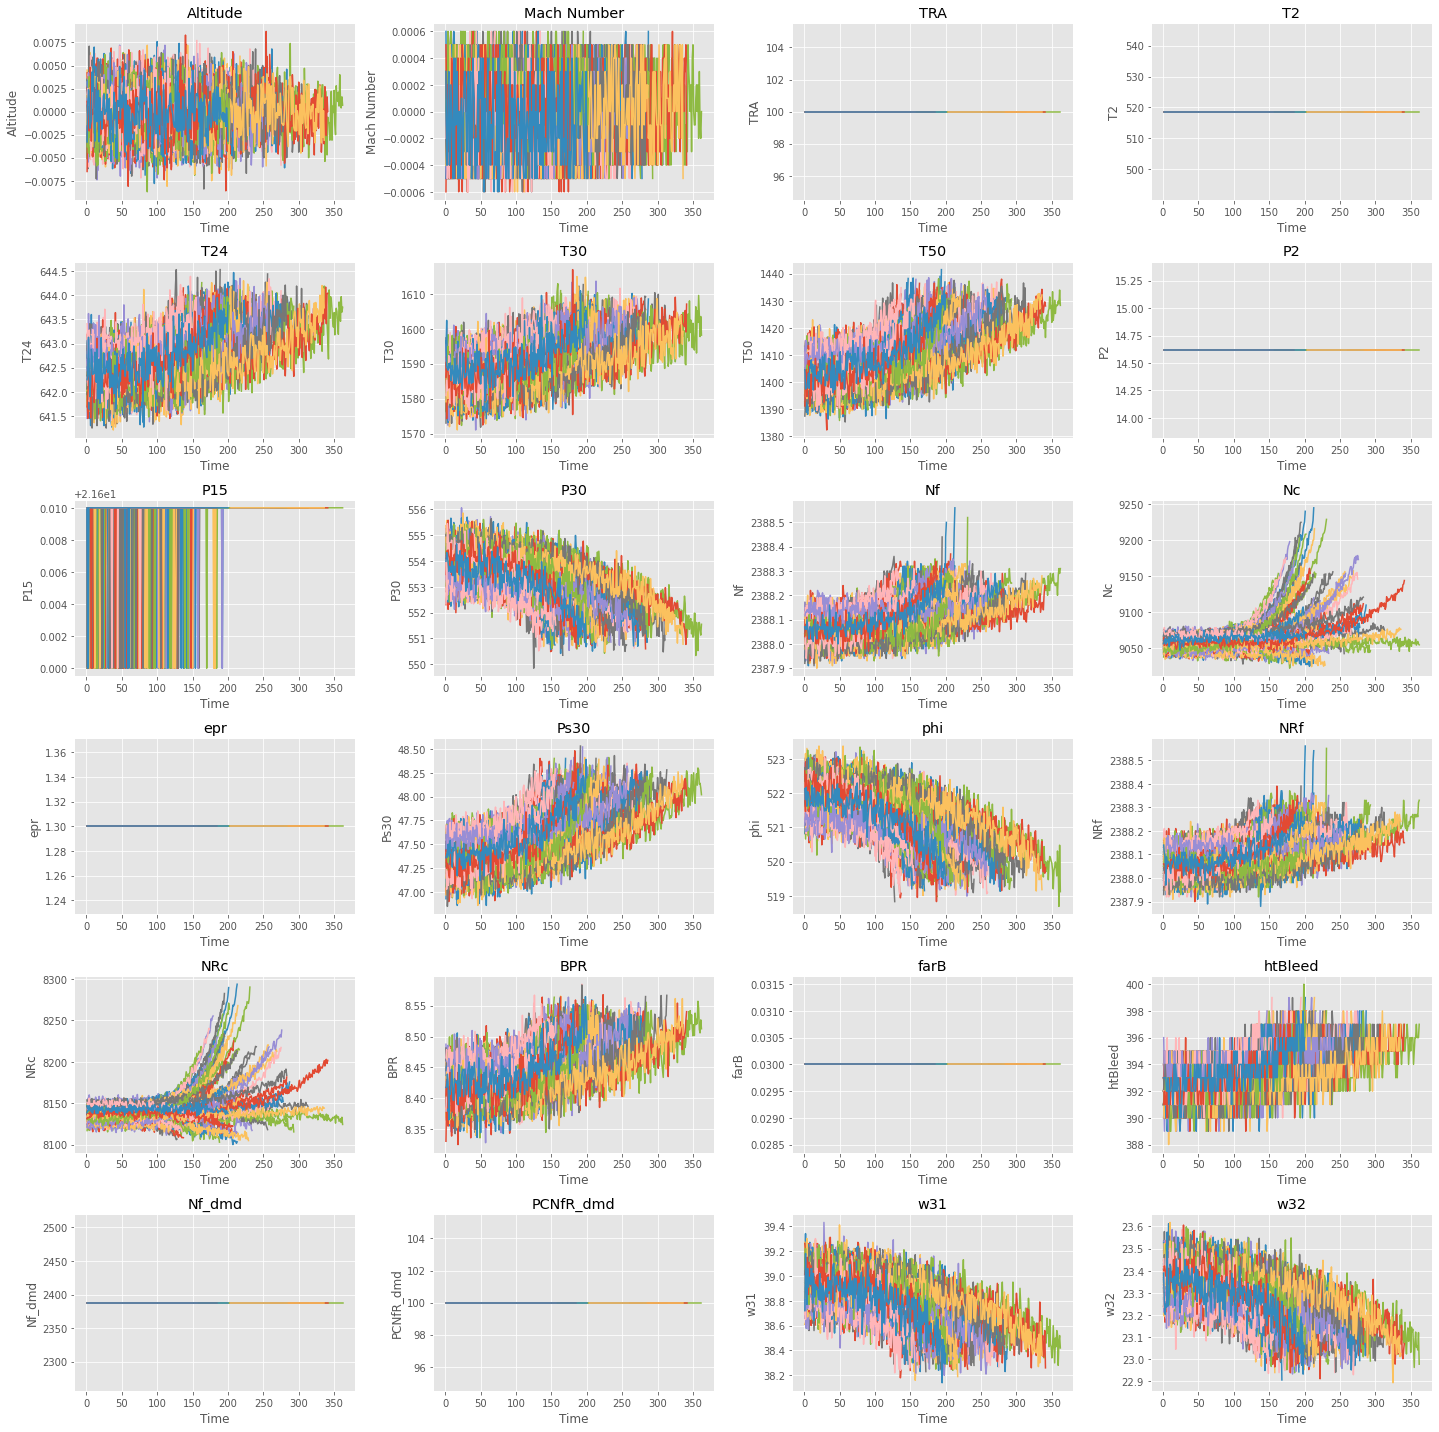

In [18]:
# visualization: look at how operating conditions and sensors are changing with time for each engine

# op setting
col2plot = col_names[2:-2]
fig = plt.figure(figsize=(20, 20))

for ii in range(len(col2plot)):
    ax = plt.subplot(math.ceil(len(col2plot)/4), 4, ii+1)

    for n, g in train1.groupby('Unit'):
        ax.plot(g['Time'], g[col2plot[ii]], label=col2plot[ii])
        ax.set_xlabel('Time')
        ax.set_ylabel(col2plot[ii])
        ax.set_title(col2plot[ii])

fig.tight_layout()
plt.show()

#### **History Plot Analysis**


From the above plots, we can see several sensors that likely do not add any valuable insights. Also, the three operating conditions should be constant, as this is a lab simulation. As such, we will drop the following sensors:  
Altitude  
Mach Number  
TRA (throttle reverse angle)  
T2 - temperature at fan inlet  
P2 - pressure at fan inlet  
P15 - pressure in bypass-duct  
epr - engine pressure ratio (P50/P2)  
farB - burner fuel-air ratio  
Nf_dmd -demanded fan speed  
PCNfR_dmd - demanded corrected fan speed  
Nf - physical fan speed  
Nc - physical core speed  

The controlled lab setting can explain most of the data observed from these sensors (ie: constant temperature, pressure, demanded speed, etc). The decision was made to drop Nf and Nc, and keep the corrected sensors NRf and Nrc.  
As T30 (HPC outet temp) increases, P30 (HPC outlet pressure) drops, and Ps30 (HPC outlet static pressure) increases until a fault is triggered

In [19]:
# New train1 dataframe with selected sensors
sensor2keep = ['T24', 'T30', 'T50', 'P15', 'P30', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'w31', 'w32']
col2keep = ['Unit', 'T24', 'T30', 'T50', 'P15', 'P30', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'w31', 'w32', 'RUL']

train1_new = train1[col2keep]
train1_new .head()

,Unit,T24,T30,T50,P15,P30,Ps30,phi,NRf,NRc,BPR,htBleed,w31,w32,RUL
0,1,641.82,1589.70,1400.60,21.61,554.36,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,642.15,1591.82,1403.14,21.61,553.75,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,642.35,1587.99,1404.20,21.61,554.26,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,642.35,1582.79,1401.87,21.61,554.45,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,642.37,1582.85,1406.22,21.61,554.00,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187


## **Bivariate Analysis** 

#### **Correlation Matrix**
*  Important to note that the correlation matrix only measures linear correlations and may miss non-linear correlations, such as those displayed in the history plots.  


**Half-Masked Correlation Matrix**

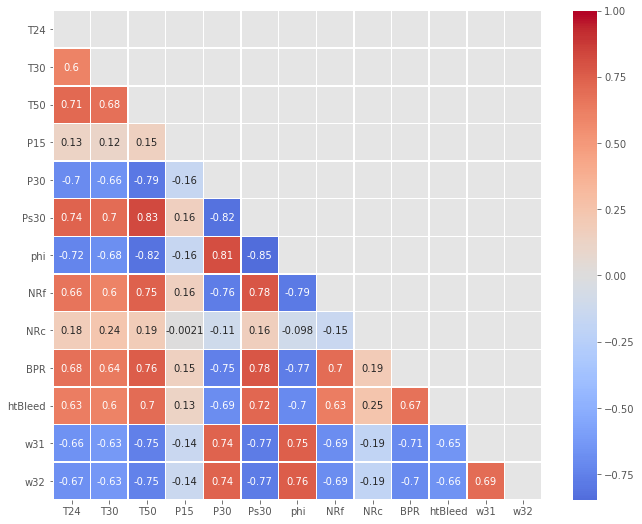

In [20]:
df = pd.DataFrame(train1_new[sensor2keep])

corrMatrix = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrMatrix, mask=mask, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5, annot=True)

In [21]:
def corr_to_target(dataframe, target, title=None, file=None):
    plt.figure(figsize=(4,6))
    sns.set(font_scale=1)
    
    sns.heatmap(dataframe.corr()[[target]].sort_values(target,
                                                ascending=False)[1:],
                annot=True,
                cmap='coolwarm')
    
    if title: plt.title(f'\n{title}\n', fontsize=18)
    plt.xlabel('')    # optional in case you want an x-axis label
    plt.ylabel('')    # optional in case you want a  y-axis label
    if file: plt.savefig(file, bbox_inches='tight')
    plt.show();
    
    return

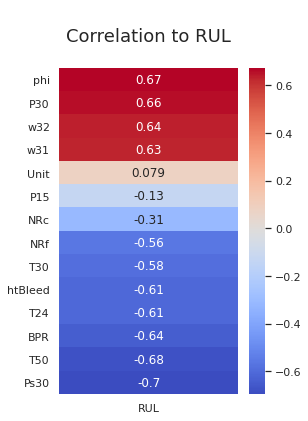

In [22]:
corr_to_target(train1_new, 'RUL', 'Correlation to RUL')